# Assignment 3 - Epipolar Geometry
**Author:** Johannes Holmgren

In [21]:
# Import external modules
# Uncomment below to have interactive 3D models
# %matplotlib widget
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
from scipy.linalg import null_space, inv, qr
import cv2
from skimage import transform

# Import internal modules/files
import plotter
import utils

In [22]:
# ----- Constants -----
MAT_PATH = 'data/mat/'      # Path to data
IMG_PATH = 'data/images/'   # Path to images
# ---------------------

----- Using normalization -----
Smallest singular value: 0.0497
||Mv|| = 0.0497
The epipolar constraints have a maximum error of 0.00795113248018419
F matrix is:
[[ 2.98731653e-09  3.27806090e-07 -5.08648427e-04]
 [-4.11282268e-07 -2.54980866e-08  2.35119098e-03]
 [ 6.33890665e-04 -2.31714260e-03 -8.81186521e-02]]
-----------
Mean distance is 0.3612

---- Without normalization ----
Smallest singular value: 0.5629
||Mv|| = 0.5629
The epipolar constraints have a maximum error of 0.09193214617218715
The fundamental matrix F for the unnormalized points are
[[-0.   -0.    0.01]
 [ 0.    0.   -0.03]
 [-0.01  0.03  1.  ]]
Mean distance is 0.4878


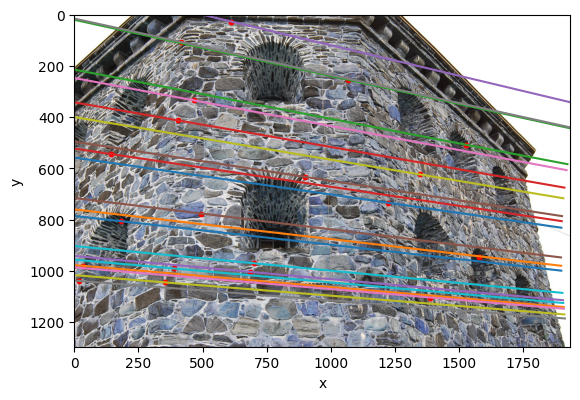

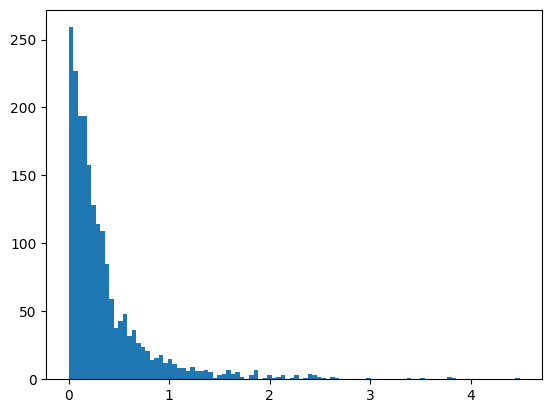

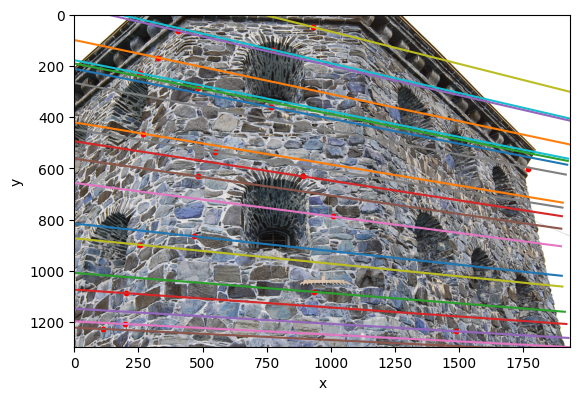

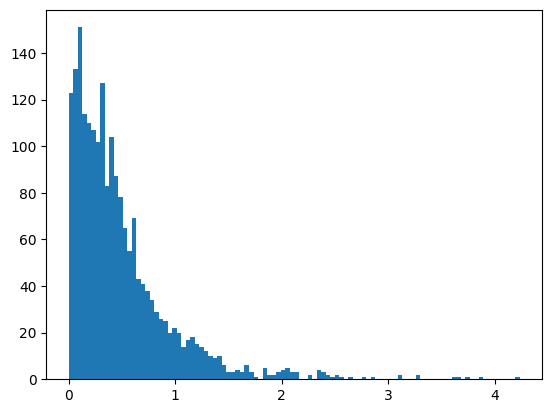

In [23]:
def estimate_F_DLT(x1s, x2s):
    ''' Solve Homogeneous least squares for DLT equations using SVD.
        Use this result to find the fundamental camera F
    
    Parameters
    ----------
    x1s: np.ndarray
        The image points for camera 1

    x2s: np.ndarray
        The image points for camera 2

    Returns
    -------
    np.ndarray
        The v-vector from the solution min(||Mv||),
        which contains the camera matrix P as its first 12 elements.
    '''
    # Set up matrix M
    n_points = x1s.shape[1]
    dim = x1s.shape[0]
    M = np.zeros([n_points, dim * dim])
    for i in range(n_points):
        xx = np.outer(x2s[:,i], x1s[:,i])
        M[i,:] = xx.flatten()
    # Solve least squares problem
    U, S, Vh = np.linalg.svd(M)
    v = Vh[-1]
    sv_min = S[-1]
    F = v.reshape((3, 3))
    return (F, M, v, sv_min)

def enforce_fundamental(F_approx: np.ndarray) -> np.ndarray:
    ''' Enforce fundamental matrix to have zero determinant
    
    Does this by performing SVD and setting the minimum singular value
    to 0 before recreating F.

    Parameters
    ----------
    F_approx: np.ndarray
        The approximated fundamental matrix F
    
    Returns
    -------
    np.ndarray:
        The fundamental matrix F with zero determinant
    '''
    U, S, Vh = np.linalg.svd(F_approx)
    S[-1] = 0
    S_diag = np.diag(S)
    F = U @ S_diag @ Vh
    return F

def psphere(v):
    ''' Normalize vectors to lie on the unit sphere. '''
    norms = np.linalg.norm(v, axis=0)
    return v / norms

def rital(ax: plt.axes, lines: np.ndarray):
    ''' Draw lines in an image
    
    Parameters
    ----------
    ax: plt.axes
        The matplotlib.pyplot axis to plot in

    lines: np.ndarray
        The homogeneous lines to plot
    
    '''
    if lines.size == 0:
        return
    n_lines = lines.shape[1]
    # Compute direction vectors orthogonal to the lines
    directions = psphere(np.array([lines[1,:], -lines[0,:], np.zeros(n_lines)]))
    # Compute points on the lines by finding intersection with z=0
    points = utils.pflat(np.cross(directions.T, lines.T).T)
    for i in range(n_lines):
        x_vals = [points[0, i] - 2000 * directions[0, i], points[0, i] + 2000 * directions[0, i]]
        y_vals = [points[1, i] - 2000 * directions[1, i], points[1, i] + 2000 * directions[1, i]]
        ax.plot(x_vals, y_vals)

def compute_epipolar_errors(F: np.ndarray, x1s: np.ndarray, x2s: np.ndarray):
    ''' Compute distance between points and their corresponding epipolar lines 
    
    Parameters
    ----------
    F: np.ndarray
        The fundamental matrix

    x1s: np.ndarray
        Image points in image 1

    x2s: np.ndarray
        Image points in image 2

    '''
    lines = np.matmul(F, x1s)
    distances = utils.point_line_distance2D(x2s, lines)
    return distances

def get_epipolar_constraint(F: np.ndarray, x1s: np.ndarray, x2s: np.ndarray) -> float:
    ''' Check what the maximum error is for the epipolar constraint for all x1s and x2s. '''
    highest = 0
    for i in range(x1s.shape[1]):
        constraint = abs(x2s[:,i].T @ F_norm @ x1s[:,i])
        if constraint > highest:
            highest = constraint
    return highest

# Computer Exercise 1
# ----- Load data -----
compEx1data = loadmat(MAT_PATH + 'compEx1data.mat')
x1       = compEx1data['x'][:,0][0]
x2       = compEx1data['x'][:,0][1]
kronan1 = cv2.imread(IMG_PATH + 'kronan1.JPG')
kronan2 = cv2.imread(IMG_PATH + 'kronan2.JPG')
# ---------------------

# ----- Part 1 -----
print('----- Using normalization -----')
# Normalize x1 and x2
N1 = utils.get_normalization_matrix(x1)
N2 = utils.get_normalization_matrix(x2)
x1_norm = N1 @ x1
x2_norm = N2 @ x2

# Construct normalized fundamental matrix F using SVD
F_approx, M, v, sv_min = estimate_F_DLT(x1_norm, x2_norm)

# Information regarding the result
Mv_norm = np.linalg.norm(M @ v)
print(f'Smallest singular value: {round(sv_min, 4)}')
print(f'||Mv|| = {round(Mv_norm, 4)}')

# Set F to closest matrix with determinant 0
F_norm = enforce_fundamental(F_approx)

# Check that epipolar constraint is fulfilled
error = get_epipolar_constraint(F_norm, x1_norm, x2_norm)
print(f'The epipolar constraints have a maximum error of {error}')

# Compute the unnormalized fundamental matrix F
F = N2.T @ F_norm @ N1

# Print F
print('F matrix is:')
print(F)
print('-----------')

# Compute epipolar lines for x1 and normalize
l = np.matmul(F, x1)
l = utils.pflat(l)
l_norms = np.sqrt(l[0, :]**2 + l[1,:]**2)
l = l / l_norms

# Pick 20 random points in image 2 and find their respective lines
n_points = 20
indices = np.random.choice(x2.shape[1], n_points)
points = x2[:,indices]
lines = l[:,indices]

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(0, kronan2.shape[1])
ax.set_ylim(kronan2.shape[0], 0)
ax.imshow(kronan2)
rital(ax, lines)
plotter.plot_points_2D(ax, points, s=10, c='r')

### Answer: The lines and the points seem relatively close, but not exactly.

# Compute the distances between points and their corresponding epipolar lines
errors = compute_epipolar_errors(F, x1, x2)
print(f'Mean distance is {round(np.mean(errors), 4)}')

# Plot distances in a histogram with 100 bins
N_BINS = 100
fig, ax = plt.subplots()
ax.hist(errors, bins=N_BINS)

# ----- Part 2 -----
print('\n---- Without normalization ----')
# Do everything but with N1 = N2 = I
N1 = np.identity(3)
N2 = np.identity(3)
x1_norm = N1 @ x1
x2_norm = N2 @ x2

# Construct normalized fundamental matrix F using SVD
F_approx, M, v, sv_min = estimate_F_DLT(x1_norm, x2_norm)

# Information regarding the result
Mv_norm = np.linalg.norm(np.matmul(M, v))
print(f'Smallest singular value: {round(sv_min, 4)}')
print(f'||Mv|| = {round(Mv_norm, 4)}')

# Set F to closest matrix with determinant 0
F_norm = enforce_fundamental(F_approx)

# Check that epipolar constraint is fulfilled
error = get_epipolar_constraint(F_norm, x1_norm, x2_norm)
print(f'The epipolar constraints have a maximum error of {error}')

# Compute the unnormalized fundamental matrix F
F = np.matmul(N2.T, np.matmul(F_norm, N1))

# Normalize matrix
F = F / F[2, 2]
print('The fundamental matrix F for the unnormalized points are')
print(F.round(2))


# Compute epipolar lines for x1 and normalize
l = np.matmul(F, x1)
l = utils.pflat(l)
l_norms = np.sqrt(l[0, :]**2 + l[1,:]**2)
l = l / l_norms

# Pick 20 random points in image 2 and find their respective lines
n_points = 20
indices = np.random.choice(x2.shape[1], n_points)
points = x2[:,indices]
lines = l[:,indices]

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(0, kronan2.shape[1])
ax.set_ylim(kronan2.shape[0], 0)
ax.imshow(kronan2)
rital(ax, lines)
plotter.plot_points_2D(ax, points, s=10, c='r')

### Answer: The lines and the points seem a bit further away

# Compute the distances between points and their corresponding epipolar lines
errors = compute_epipolar_errors(F, x1, x2)
print(f'Mean distance is {round(np.mean(errors), 4)}')

# Plot distances in a histogram with 100 bins
N_BINS = 100
fig, ax = plt.subplots()
ax.hist(errors, bins=N_BINS)

# Show everything
plt.show()

In [24]:
def enforce_essential(E_approx: np.ndarray) -> np.ndarray:
    ''' Enforce the Essential matrix by setting its singular values to [1 1 0]. 
    
    '''
    U, S, Vh = np.linalg.svd(E_approx)
    S_diag = np.diag([1, 1, 0])
    return U @ S_diag @ Vh

In [25]:
def convert_E_to_F(E: np.ndarray, K1: np.ndarray, K2: np.ndarray) -> np.ndarray:
    ''' Get Fundamental matrix F from Essential matrix E.
    
    Using the formula K2^(T)FK1
    '''
    return K2.T @ E @ K1

Smallest singular value: 0.0066
||Mv|| = 0.0066
The essential matrix E is
[[-0.   -0.36  0.14]
 [ 0.45  0.03 -0.88]
 [-0.17  0.92  0.  ]]
[1.00000000e+00 1.00000000e+00 1.38870243e-16]
The epipolar constraints have a maximum error of 0.9996054471673382
Mean distance is 2.0838


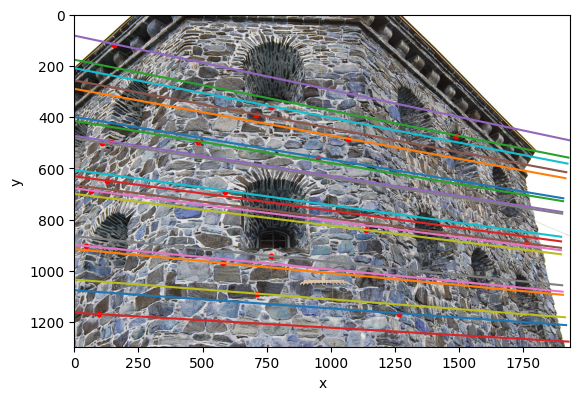

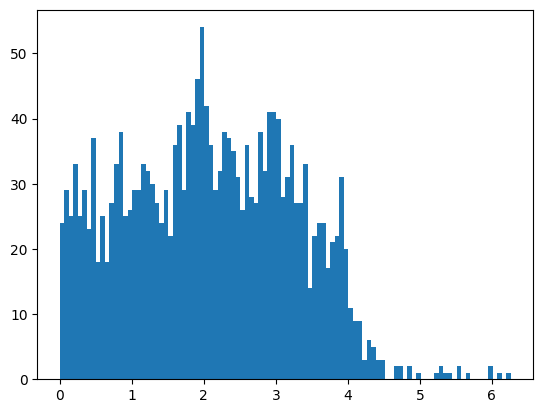

In [ ]:
# Computer Exercise 2

# ----- Load data -----
compEx1data = loadmat(MAT_PATH + 'compEx1data')
compEx2data = loadmat(MAT_PATH + 'compEx2data.mat')

x1 = compEx1data['x'][:,0][0]
x2 = compEx1data['x'][:,0][1]
K  = compEx2data['K']

kronan1     = cv2.imread(IMG_PATH + 'kronan1.JPG')
kronan2     = cv2.imread(IMG_PATH + 'kronan2.JPG')
# ---------------------

# Normalize image points
K_inv = inv(K)
x1_norm = K_inv @ x1
x2_norm = K_inv @ x2

# Get essential matrix
E_approx, M, v, sv_min = estimate_F_DLT(x1_norm, x2_norm)

# Information regarding the result
Mv_norm = np.linalg.norm(M @ v)
print(f'Smallest singular value: {round(sv_min, 4)}')
print(f'||Mv|| = {round(Mv_norm, 4)}')

# Ensure E has two equal singular values and one zero
E = enforce_essential(E_approx)

print('The essential matrix E is')
print(E.round(2))

# Check that epipolar constraint is roughly fulfilled
error = get_epipolar_constraint(F_norm, x1_norm, x2_norm)
print(f'The epipolar constraints have a maximum error of {error}')

# Compute the Fundamental matrix F from the Essential matrix E
F = convert_E_to_F(E, K_inv, K_inv)

# Compute epipolar lines for x1 and normalize
l = np.matmul(F, x1)
l = utils.pflat(l)
l_norms = np.sqrt(l[0, :]**2 + l[1,:]**2)
l = l / l_norms

# Pick 20 random points in image 2 and find their respective lines
n_points = 20
indices = np.random.choice(x2.shape[1], n_points)
points = x2[:,indices]
lines = l[:,indices]

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(0, kronan2.shape[1])
ax.set_ylim(kronan2.shape[0], 0)
ax.imshow(kronan2)
rital(ax, lines)
plotter.plot_points_2D(ax, points, s=10, c='r')

# Compute the distances between points and their corresponding epipolar lines
errors = compute_epipolar_errors(F, x1, x2)
print(f'Mean distance is {round(np.mean(errors), 4)}')

# Plot distances in a histogram with 100 bins
N_BINS = 100
fig, ax = plt.subplots()
ax.hist(errors, bins=N_BINS)

### Answers: The errors seem to be worse than the normalized case in Computer Exercise 1,
###          and almost as bad as the non-normalized case in Computer Exercise 1.

# Show everything
plt.show()

In [27]:
def extract_P_from_E(E: np.ndarray) -> np.ndarray:
    ''' Get all camera matrix P from Essential matrix E. '''

    # Set upp all matrices needed
    U, _, Vh = np.linalg.svd(E)
    W = np.array([
        [0, -1, 0],
        [1, 0, 0],
        [0, 0, 1]
    ])
    u3 = U[:,2].reshape(-1, 1)

    # Assert det(U*V) > 0
    Vh = Vh if np.linalg.det(U @ Vh) > 0 else -Vh

    # Compute the four camera solutions
    P21 = np.concat([U @ W   @ Vh,  u3], axis=1)
    P22 = np.concat([U @ W   @ Vh, -u3], axis=1)
    P23 = np.concat([U @ W.T @ Vh,  u3], axis=1)
    P24 = np.concat([U @ W.T @ Vh, -u3], axis=1)
    return np.array([P21, P22, P23, P24])



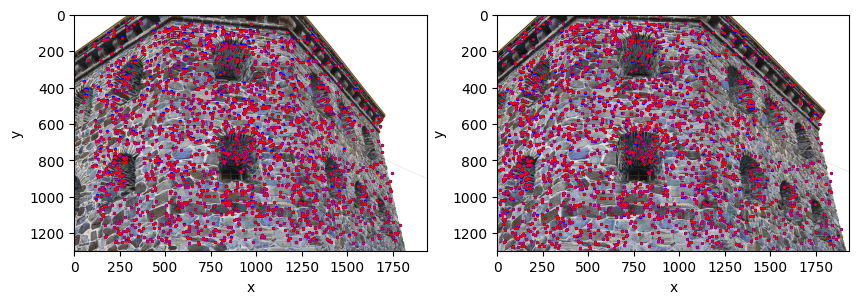

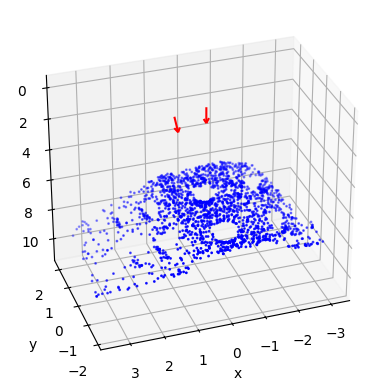

In [28]:
# Computer Exercise 3

# Get all P matrices from E
P2s = extract_P_from_E(E)
P1_norm = np.eye(3, 4)

# Triangulate points for each of the camera matrices P2
Xs = np.array([utils.triangulate_3D_point_DLT(x1_norm, x2_norm, P1_norm, P2) for P2 in P2s])

# Determine which set of points X are in front of both cameras (mostly)
# Do this by projecting onto each camera and count z-indices > 0
best_index = 0
P_max = 0
for i, (X, P2) in enumerate(zip(Xs, P2s)):
    x1_proj = P1_norm @ X
    x2_proj = P2 @ X
    n_front_1 = (x1_proj[2] > 0).sum()
    n_front_2 = (x2_proj[2] > 0).sum()
    if (tot := n_front_1 + n_front_2) > P_max:
        P_max = tot
        best_index = i

P2_norm = P2s[best_index]
X = Xs[best_index]

# Compute corresponding camera matrices
P1 = K @ P1_norm
P2 = K @ P2_norm

# Project triangulated 3D points onto each camera
x1_proj = utils.pflat(P1 @ X)
x2_proj = utils.pflat(P2 @ X)

# Set up figure
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.set_figheight(5)

axs[0].set_aspect('equal')
axs[0].set_xlim(0, kronan1.shape[1])
axs[0].set_ylim(kronan1.shape[0], 0)

axs[1].set_aspect('equal')
axs[1].set_xlim(0, kronan1.shape[1])
axs[1].set_ylim(kronan1.shape[0], 0)

# Plot images
axs[0].imshow(kronan1)
axs[1].imshow(kronan2)

# Plot image points
plotter.plot_points_2D(axs[0], x1, c='b', s=2)
plotter.plot_points_2D(axs[1], x2, c='b', s=2)

# Plot projected triangulated 3D points
plotter.plot_points_2D(axs[0], x1_proj, c='r', s=1)
plotter.plot_points_2D(axs[1], x2_proj, c='r', s=1)

### Answers: The points seem to lie very close to each other

# Plot 3D points and cameras
fig_3D = plt.figure()
ax_3D = fig_3D.add_subplot(projection='3d')
ax_3D.view_init(elev=-149, azim=109, roll=0)

# Plot points
plotter.plot_points_3D(ax_3D, X, 'b')

# Plot cameras
P1_center, P1_axis = utils.camera_center_and_axis(P1)
P2_center, P2_axis = utils.camera_center_and_axis(P2)

plotter.plot_camera(ax_3D, P1_center, P1_axis, scale=1)
plotter.plot_camera(ax_3D, P2_center, P2_axis, scale=1)

### Answer: Yes, the triangulated 3D points look like expected

# Show everything
plt.show()